# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [67]:
import cv2,csv
import numpy as np
import pandas as pd
import os
from tensorflow.keras.applications.mobilenet import preprocess_input, MobileNet
from tensorflow.keras.layers import Conv2D,Reshape
from tensorflow.keras import Model
from tensorflow.keras.backend import epsilon
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau, Callback
import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Change directory

In [7]:
os.chdir(r"/content/drive/My Drive/lab/ACV Lab Questions and Data Set/ACV Lab Questions and Data Set")

### Load the training data from train.csv file

In [8]:
traindf = pd.read_csv("train_labels.csv")

In [9]:
traindf

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127
...,...,...,...,...,...,...,...,...
168,raccoon-137.jpg,320,240,raccoon,71,8,304,233
169,raccoon-171.jpg,224,225,raccoon,108,21,180,115
170,raccoon-190.jpg,259,194,raccoon,78,54,153,135
171,raccoon-22.jpg,640,360,raccoon,252,76,466,335


### Print the shape of the train dataset

In [10]:
traindf.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [11]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [48]:
paths = []
dir = "./images_racoon/images/images/" 
with open('train_labels.csv', 'r') as file:
    coords = np.zeros((sum(1 for line in file)-1, 4))   #creating a placeholder for coordinates
    print(coords.shape)
    file.seek(0)  # set current offset position in file
    traindata = csv.reader(file, delimiter = ',')   #read thr the file
    header = next(traindata)    # Fetch the header
    print(header)

    for col, row in enumerate(traindata):  
        for i, r in enumerate(row[1:8]):# Parse row with seven entities
            if r.isdigit(): row[i+1] = int(r)       # converting to int for columns apart from classes

        if header!= None:
            
            path, width, height,_, x0,y0,x1,y1 = row
            coords[col,0] = x0 * IMAGE_SIZE / width
            coords[col,1] = y0 * IMAGE_SIZE / height
            coords[col,2] = (x1-x0 )* IMAGE_SIZE / width
            coords[col,3] = (y1-y0) * IMAGE_SIZE / width
            paths.append( dir + path)
    
print(paths)
#print(coords)

(173, 4)
['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
['./images_racoon/images/images/raccoon-17.jpg', './images_racoon/images/images/raccoon-11.jpg', './images_racoon/images/images/raccoon-63.jpg', './images_racoon/images/images/raccoon-63.jpg', './images_racoon/images/images/raccoon-60.jpg', './images_racoon/images/images/raccoon-69.jpg', './images_racoon/images/images/raccoon-180.jpg', './images_racoon/images/images/raccoon-200.jpg', './images_racoon/images/images/raccoon-141.jpg', './images_racoon/images/images/raccoon-19.jpg', './images_racoon/images/images/raccoon-84.jpg', './images_racoon/images/images/raccoon-124.jpg', './images_racoon/images/images/raccoon-182.jpg', './images_racoon/images/images/raccoon-111.jpg', './images_racoon/images/images/raccoon-91.jpg', './images_racoon/images/images/raccoon-79.jpg', './images_racoon/images/images/raccoon-93.jpg', './images_racoon/images/images/raccoon-20.jpg', './images_racoon/images/images/raccoon-42.jpg',

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [90]:
#img_path = "./images_racoon/images/images/" 
batch_images = []
for p in paths:
    
    image = cv2.imread(p,cv2.IMREAD_COLOR)
    if image is None: continue
    image = cv2.resize(image,(128,128))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    batch_images.append(image)


In [ ]:
#image = cv2.imread(img_path + '/{}'.format(p),1)

In [91]:
batch_images = np.array(batch_images)
batch_images.shape

(173, 128, 128, 3)

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [143]:
model = MobileNet(input_shape=(128, 128, 3), include_top=False) 
for layer in model.layers:
    layer.trainable = False
model1 = model.layers[-1].output
model1 = Conv2D(4, kernel_size=4)(model1)
model1 = Reshape((4,))(model1)

myModel = Model(inputs=model.input,outputs = model1)

In [144]:
myModel.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)       

### Define a custom loss function IoU which calculates Intersection Over Union

In [93]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

In [148]:
batch_images.shape, coords.shape

((173, 128, 128, 3), (173, 4))

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [145]:
myModel.compile(loss="mse", optimizer="adam", metrics=[IoU]) 
myModel.fit(batch_images, coords, epochs=30,
                    batch_size = 32,                                      
                    workers=7,
                    use_multiprocessing=True,
                    shuffle=True,
                    verbose=1) 

Epoch 1/30
6/6 [==============================] - 2s 331ms/step - loss: 2639.0378 - IoU: 0.0528
Epoch 2/30
6/6 [==============================] - 2s 329ms/step - loss: 904.4350 - IoU: 0.3219
Epoch 3/30
6/6 [==============================] - 2s 329ms/step - loss: 663.7571 - IoU: 0.4588
Epoch 4/30
6/6 [==============================] - 2s 330ms/step - loss: 735.1025 - IoU: 0.4404
Epoch 5/30
6/6 [==============================] - 2s 331ms/step - loss: 592.1489 - IoU: 0.4472
Epoch 6/30
6/6 [==============================] - 2s 336ms/step - loss: 468.9920 - IoU: 0.5002
Epoch 7/30
6/6 [==============================] - 2s 330ms/step - loss: 441.4703 - IoU: 0.4904
Epoch 8/30
6/6 [==============================] - 2s 329ms/step - loss: 400.5027 - IoU: 0.5094
Epoch 9/30
6/6 [==============================] - 2s 332ms/step - loss: 361.4073 - IoU: 0.5522
Epoch 10/30
6/6 [==============================] - 2s 340ms/step - loss: 333.6751 - IoU: 0.5651
Epoch 11/30
6/6 [==============================]

In [150]:
myModel.compile(loss="mse", optimizer="adamax", metrics=[IoU]) # Regression loss is MSE
checkpoint = ModelCheckpoint("model-{IoU:.2f}.h5", monitor="IoU", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", save_freq = 20) # Checkpoint best validation model
stop = EarlyStopping(monitor="IoU", patience=10, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="IoU", factor=0.2, patience=20, min_lr=1e-9, verbose=1, mode="max")
myModel.fit(batch_images, coords, epochs=100,
                    batch_size = 32, 
                    callbacks=[checkpoint, reduce_lr, stop],                   
                    workers=7,
                    use_multiprocessing=True,
                    shuffle=True,
                    verbose=1) 

Epoch 1/100
6/6 [==============================] - 2s 325ms/step - loss: 62.6103 - IoU: 0.8234
Epoch 2/100
6/6 [==============================] - 2s 321ms/step - loss: 56.7105 - IoU: 0.8435
Epoch 3/100
6/6 [==============================] - 2s 339ms/step - loss: 53.5517 - IoU: 0.8609
Epoch 4/100
1/6 [====>.........................] - ETA: 0s - loss: 114.3552 - IoU: 0.8365
Epoch 00004: IoU improved from -inf to 0.85360, saving model to model-0.85.h5
6/6 [==============================] - 3s 438ms/step - loss: 51.7990 - IoU: 0.8683
Epoch 5/100
6/6 [==============================] - 2s 336ms/step - loss: 50.6543 - IoU: 0.8754
Epoch 6/100
6/6 [==============================] - 2s 336ms/step - loss: 50.0580 - IoU: 0.8685
Epoch 7/100
3/6 [==============>...............] - ETA: 0s - loss: 55.5489 - IoU: 0.8916
Epoch 00007: IoU improved from 0.85360 to 0.89115, saving model to model-0.89.h5
6/6 [==============================] - 2s 375ms/step - loss: 48.9651 - IoU: 0.8865
Epoch 8/100
6/6 [====

### Pick a test image from the given data

In [110]:
#Testing images on outside image sub folder -> Treated as test images (not used for training)
filename = './images_racoon/images/raccoon-34.jpg'
testimg = cv2.imread(filename)
testimg_ht, testimg_width,_ = testimg.shape 

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [135]:
resized_testimg = cv2.resize(testimg,(IMAGE_SIZE,IMAGE_SIZE))
testimg_prepr = preprocess_input(np.array(resized_testimg,dtype = np.float32))

### Predict the coordinates of the bounding box for the given test image

In [133]:
region = myModel.predict(x =np.array([testimg_prepr]))[0]

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

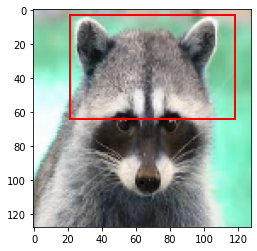

In [147]:


x0 = int(region[0] * width / IMAGE_SIZE)  # Scale the BBox
y0 = int(region[1] * height / IMAGE_SIZE)

x1 = int((region[2]) * width / IMAGE_SIZE)
y1 = int((region[3]) * height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
#ax.imshow(testimg)
ax.imshow(resized_testimg)


# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

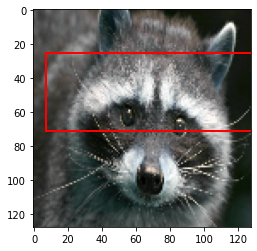

In [158]:
#Testing train images

filename = './images_racoon/images/images/raccoon-3.jpg'
testimg = cv2.imread(filename)
testimg_ht, testimg_width,_ = testimg.shape 
resized_testimg = cv2.resize(testimg,(IMAGE_SIZE,IMAGE_SIZE))
testimg_prepr = preprocess_input(np.array(resized_testimg,dtype = np.float32))
region = myModel.predict(x =np.array([testimg_prepr]))[0]
x0 = int(region[0] * width / IMAGE_SIZE)  # Scale the BBox
y0 = int(region[1] * height / IMAGE_SIZE)

x1 = int((region[2]) * width / IMAGE_SIZE)
y1 = int((region[3]) * height / IMAGE_SIZE)


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
#ax.imshow(testimg)
ax.imshow(resized_testimg)


# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()